In [1]:
import sklearn as sk
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [2]:
# First, lets construct the different models that we will use.
from sklearn import tree
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import svm
from sklearn import neural_network
from sklearn import ensemble

# Read data-engineered CSV.
df = pd.read_csv('H-2B_Engineered_Data.csv')
labels = df.loc[:,'CASE_STATUS']
features = pd.DataFrame(df.drop(labels = ['CASE_STATUS'], axis = 1))

In [5]:
from sklearn import decomposition
from sklearn import preprocessing as pp
from sklearn import neighbors as knn
from sklearn import pipeline
from sklearn import model_selection
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler

# Build a preprocessor to scale numeric features and one hot encode categorical features.
numeric_features = ['NBR_WORKERS_REQUESTED', 
                    'BASIC_NUMBER_OF_HOURS', 
                    'BASIC_RATE_OF_PAY', 
                    'SUPERVISE_HOW_MANY', 
                    'NUM_OF_MONTHS_TRAINING',
                    'EMP_EXP_NUM_MONTHS',
                    'WORK_DAY_LENGTH']
categorical_features = ["AGENT_POC_EMP_REP_BY_AGENT", 
                        "SOC_CODE", 
                        "NAICS_CODE", 
                        "FULL_TIME_POSITION", 
                        "NATURE_OF_TEMPORARY_NEED", 
                        "EDUCATION_LEVEL", 
                        "SWA_NAME", 
                        "CITY_MATCH", 
                        "STATE_MATCH", 
                        "DAYTIME_WORK", 
                        "HAS_OVERTIME"]

# Get indices of numeric and categorical feature columns in dataframe.
numeric_feature_names = set(numeric_features)
categorical_feature_names = set(categorical_features)

numeric_feature_indices = []
categorical_feature_indices = []

for index, column_name in enumerate(features.columns):
    if column_name in numeric_feature_names:
        numeric_feature_indices.append(index)
    elif column_name in categorical_feature_names:
        categorical_feature_indices.append(index)

# Scale numeric features.
numeric_transformer = pipeline.Pipeline(steps=[
    ('scaler', pp.StandardScaler())])

# One-hot encode categorical features.
categorical_transformer = pipeline.Pipeline(steps=[
    ('onehot', pp.OneHotEncoder(sparse = False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature_indices),
        ('cat', categorical_transformer, categorical_feature_indices)])
        
random_state_val = 123
undersample = ClusterCentroids(sampling_strategy = 0.33, random_state = random_state_val)
oversample = RandomOverSampler(sampling_strategy = 1, random_state = random_state_val)

Visualization of datapoint distribution, post pre-processing and PCA:

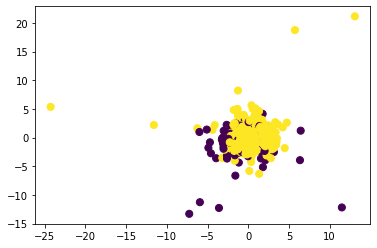

In [30]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

fitted_features = preprocessor.fit_transform(features)
pca_features = decomposition.PCA().fit_transform(fitted_features)

def scatter(data, labels, numPoints = 1000):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data[start:end, :]
    labels = labels[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

scatter(pca_features, labels)

Here, we'll be determining the best parameters for Decision Tree, K Nearest Neighbors, SVM, Random Forest Classifier, and MLP Classifier.

In [7]:
# Decision Tree
tuned_parameters = {
    'tree__max_depth': [5, 10, 15, 20],
#     'tree__min_samples_leaf': [5, 10, 15, 20], 
#     'tree__max_features': [5, 10, 15],
#     'tree__criterion': ['gini', 'entropy']
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('tree', tree.DecisionTreeClassifier())])
tree_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
tree_model.fit(features, labels)
print(tree_model.best_params_)
print(tree_model.best_score_)

KeyboardInterrupt: 

In [5]:
# K Nearest Neighbors
tuned_parameters = {
    'knn__n_neighbors': list(range(1, 25))
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('knn', neighbors.KNeighborsClassifier())])
knn_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
knn_model.fit(features, labels)
print(knn_model.best_params_)
print(knn_model.best_score_)

{'knn__n_neighbors': 1}
0.8244648318042813


In [8]:
from sklearn.svm import LinearSVC

# Support Vector Machine
tuned_parameters = {
    "svm__loss": ['hinge', 'squared_hinge'],
#     'svm__C': [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
}

svc = LinearSVC()

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('svm', svc)])
svm_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
svm_model.fit(features, labels)
print(svm_model.best_params_)
print(svm_model.best_score_)

{'svm__loss': 'squared_hinge'}
0.831039755351682


In [4]:
# Neural Network
tuned_parameters = {
    'net__activation': ['logistic', 'tanh', 'relu'],
    'net__solver': ['sgd', 'adam']
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('net', neural_network.MLPClassifier())])
net_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
net_model.fit(features, labels)
print(net_model.best_params_)
print(net_model.best_score_)

warnings.simplefilter("default")

{'net__activation': 'logistic', 'net__solver': 'sgd'}
0.8414373088685015


In [6]:
warnings.simplefilter("ignore")
# Random Forest Classifier
tuned_parameters = {
    'rfc__max_depth': list(range(35, 56)),
    'rfc__min_samples_leaf': list(range(8, 13, 2)),
    'rfc__max_features': ['sqrt', 'log2']
}

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('rfc', ensemble.RandomForestClassifier(n_estimators=10))])
rfc_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
rfc_model.fit(features, labels)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'rfc__max_depth': 44, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 8}
0.8451070336391437


Now, we create our classifiers based on the best tuned parameters.

We use these classifiers to create an ensemble voting classifier, hosting a Decision Tree, Random Forest, KNN, Gaussian Naive Bayes, Support Vvector Machine, and Neural Network classifier.

In [8]:
classifiers = []

# Classifiers.
tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10, min_samples_leaf=10)
classifiers.append(('tree', tree))

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=44, max_features='sqrt', min_samples_leaf=8)
classifiers.append(('rfc', rfc))

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
classifiers.append(('knn', knn))

nb = naive_bayes.GaussianNB()
classifiers.append(('nb', nb))

sv = LinearSVC(C=1.5, loss='hinge')
classifiers.append(('svm', sv))

net = neural_network.MLPClassifier(activation='logistic', solver='sgd')
classifiers.append(('neural_network', net))

In [9]:
# Results from the Individual Classifiers.

warnings.simplefilter("ignore")

for name, cl in classifiers:
    pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('classifier', cl)])
    pr = model_selection.cross_val_predict(pipe, features, labels, cv=5)
    
    print(cl)
    print(metrics.confusion_matrix(labels, pr))
    print(metrics.classification_report(labels, pr))
    
warnings.simplefilter("default")

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
[[ 434  355]
 [ 951 4800]]
              precision    recall  f1-score   support

           0       0.31      0.55      0.40       789
           1       0.93      0.83      0.88      5751

    accuracy                           0.80      6540
   macro avg       0.62      0.69      0.64      6540
weighted avg       0.86      0.80      0.82      6540

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=44, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
           

In [10]:
voting = ensemble.VotingClassifier(classifiers)

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('classifier', voting)])

warnings.simplefilter("ignore")
pr = model_selection.cross_val_predict(pipe, features, labels, cv=5)
warnings.simplefilter("default")
    
print(voting)
print(metrics.confusion_matrix(labels, pr))
print(metrics.classification_report(labels, pr))

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=10,
                                                     max_features=10,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=10,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best')),
    